preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Dataset length: 8092
Dataset length: 8093
Dataset length: 9711
Dataset length: 6474
Dataset length: 11329
Dataset length: 4856


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on 50-50 split...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1725982619.138783     104 service.cc:145] XLA service 0x5645b4c1f7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725982619.138834     104 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725982619.293502     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


253/253 [==============================] - 574s 1s/step - loss: 4.9126 - accuracy: 0.0482 - val_loss: 4.0694 - val_accuracy: 0.1528
Epoch 2/10
253/253 [==============================] - 418s 1s/step - loss: 3.1369 - accuracy: 0.3407 - val_loss: 2.7693 - val_accuracy: 0.3864
Epoch 3/10
253/253 [==============================] - 416s 1s/step - loss: 1.8396 - accuracy: 0.6462 - val_loss: 2.0326 - val_accuracy: 0.5555
Epoch 4/10
253/253 [==============================] - 419s 1s/step - loss: 1.0665 - accuracy: 0.8303 - val_loss: 1.6615 - val_accuracy: 0.6236
Epoch 5/10
253/253 [==============================] - 418s 1s/step - loss: 0.6350 - accuracy: 0.9163 - val_loss: 1.4534 - val_accuracy: 0.6591
Epoch 6/10
253/253 [==============================] - 420s 1s/step - loss: 0.3887 - accuracy: 0.9593 - val_loss: 1.3253 - val_accuracy: 0.6794
Epoch 7/10
253/253 [==============================] - 416s 1s/step - loss: 0.2661 - accuracy: 0.9737 - val_loss: 1.2694 - val_accuracy: 0.6938
Epoch 8/10

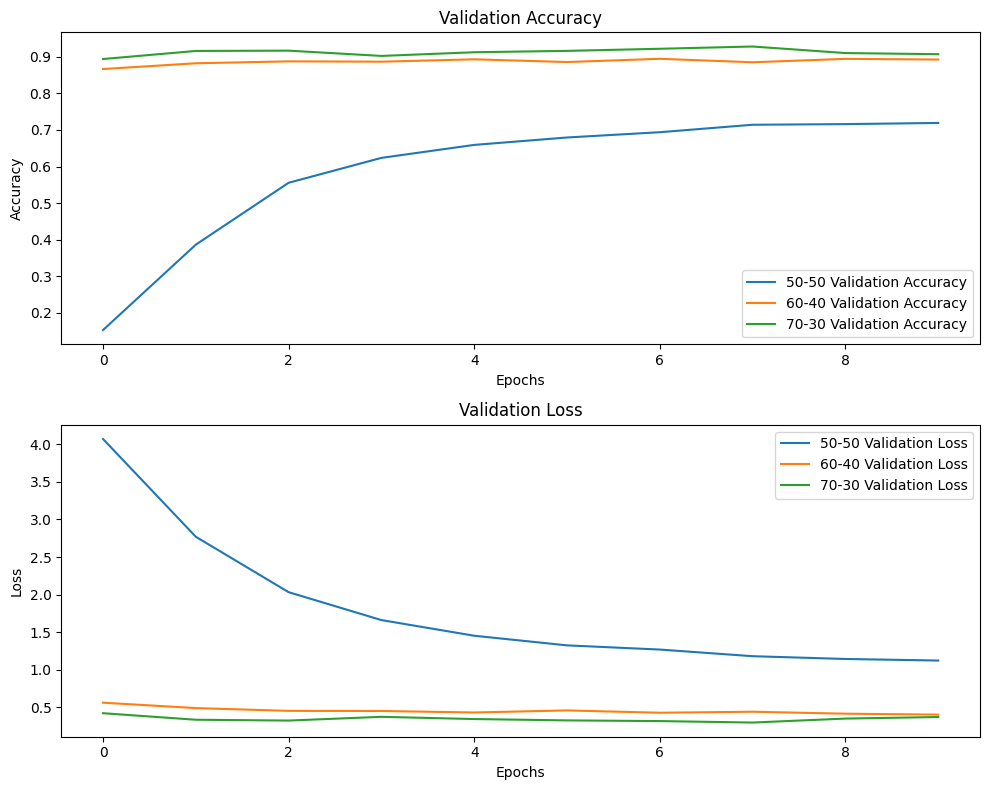

In [1]:
import tensorflow as tf
from transformers import ViTFeatureExtractor, TFViTModel
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


train_dir = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train"
test_dir = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test"
img_size = (224, 224)
batch_size = 32
checkpoint_path = "./best_model_checkpoint.h5"


classes = sorted(os.listdir(train_dir))


feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')


def load_and_preprocess_image(img_path, label):
    if not tf.io.gfile.exists(img_path) or tf.io.gfile.isdir(img_path):
        raise ValueError(f"{img_path} is not a valid file.")

    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    
    # Data augmentation
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    
    img = tf.cast(img, tf.float32) / 255.0  
    
    img_np = img.numpy()
    pil_image = Image.fromarray((img_np * 255).astype(np.uint8))

    pixel_values = feature_extractor(images=pil_image, return_tensors='np')['pixel_values']
    pixel_values = tf.convert_to_tensor(pixel_values, dtype=tf.float32)  
    pixel_values = tf.squeeze(pixel_values, axis=0)  

    return pixel_values, label  


def preprocess_dataset(file_paths, labels, batch_size, shuffle=False):
    def gen():
        for path, label in zip(file_paths, labels):
            try:
                yield load_and_preprocess_image(path, label)
            except Exception as e:
                print(f"Skipping file {path} due to error: {e}")
    
    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(3, 224, 224), dtype=tf.float32),  # Updated shape
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    
    dataset_length = len(file_paths)
    print("Dataset length:", dataset_length)
    
    if shuffle and dataset_length > 0:
        dataset = dataset.shuffle(buffer_size=min(dataset_length, 10000))  
    dataset = dataset.batch(batch_size)

    return dataset


def split_dataset(file_paths, labels, split_ratio):
    train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(
        file_paths, labels, test_size=split_ratio, stratify=labels, random_state=42)
    return train_file_paths, train_labels, test_file_paths, test_labels


def get_file_paths_and_labels(directory):
    file_paths = []
    labels = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  
            for fname in os.listdir(class_dir):
                full_path = os.path.join(class_dir, fname)
                if os.path.isfile(full_path):  
                    file_paths.append(full_path)
                    labels.append(classes.index(class_name))
    return file_paths, labels


train_file_paths, train_labels = get_file_paths_and_labels(train_dir)
test_file_paths, test_labels = get_file_paths_and_labels(test_dir)


splits = {"50-50": 0.5, "60-40": 0.4, "70-30": 0.3}
datasets = {}

for split_name, split_ratio in splits.items():
    train_file_paths_split, train_labels_split, test_file_paths_split, test_labels_split = split_dataset(
        train_file_paths + test_file_paths, train_labels + test_labels, split_ratio
    )
    train_ds = preprocess_dataset(train_file_paths_split, train_labels_split, batch_size, shuffle=True)
    test_ds = preprocess_dataset(test_file_paths_split, test_labels_split, batch_size, shuffle=False)
    datasets[split_name] = (train_ds, test_ds)


def visualize_history(histories):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    for split_name, history in histories.items():
        axes[0].plot(history.history['val_accuracy'], label=f'{split_name} Validation Accuracy')
        axes[1].plot(history.history['val_loss'], label=f'{split_name} Validation Loss')

    axes[0].set_title('Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].set_title('Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224')

def create_model():
    inputs = tf.keras.Input(shape=(3, 224, 224), dtype=tf.float32)
    
    features = base_model(inputs)[0]  
    pooled_features = tf.keras.layers.GlobalAveragePooling1D()(features)  
    
    num_classes = len(classes)
    logits = tf.keras.layers.Dense(num_classes, activation='softmax')(pooled_features)
    
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model


model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


histories = {}

for split_name, (train_ds, val_ds) in datasets.items():
    print(f"Training on {split_name} split...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[checkpoint_callback]
    )
    histories[split_name] = history


visualize_history(histories)


1/1 [==============================] - 9s 9s/step


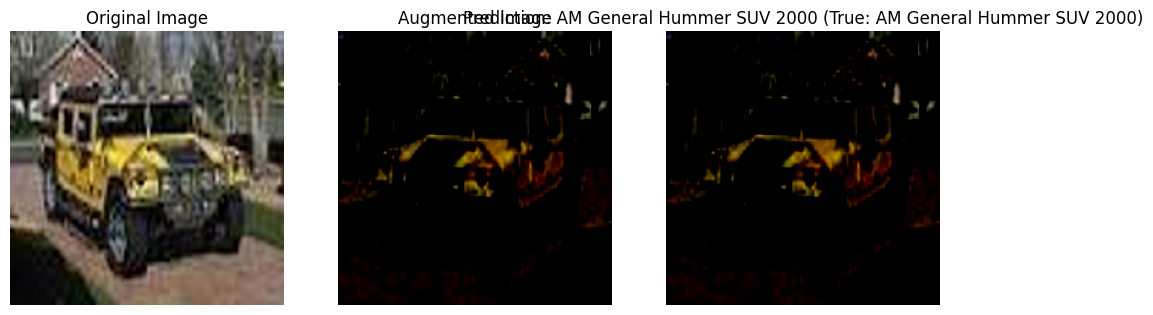

1/1 [==============================] - 0s 43ms/step


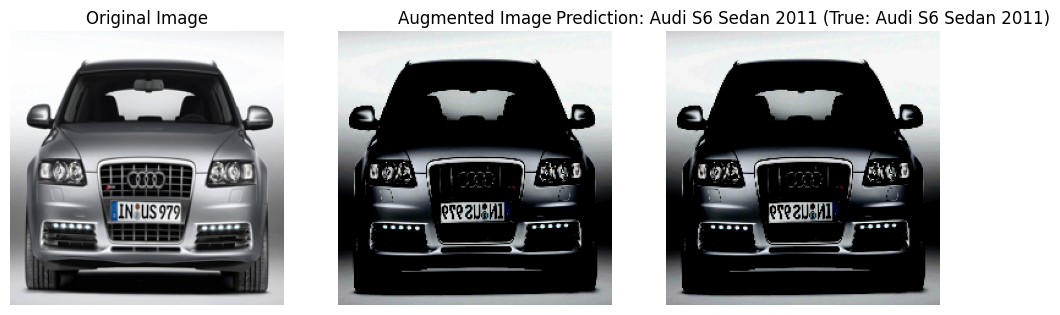

1/1 [==============================] - 0s 42ms/step


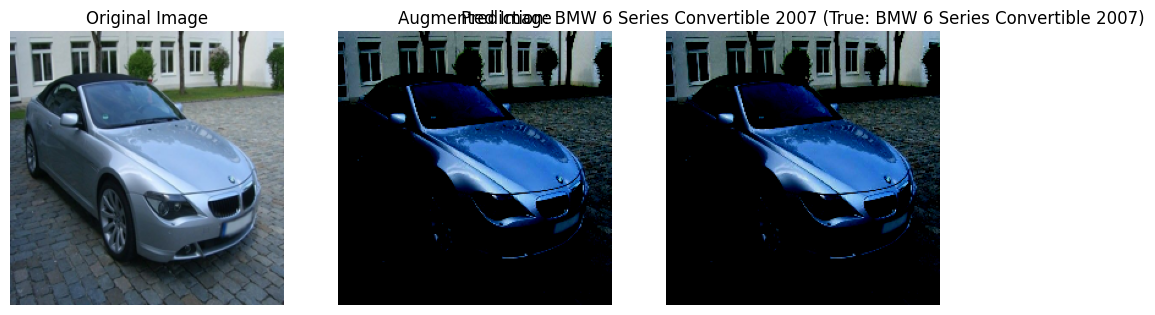

1/1 [==============================] - 0s 42ms/step


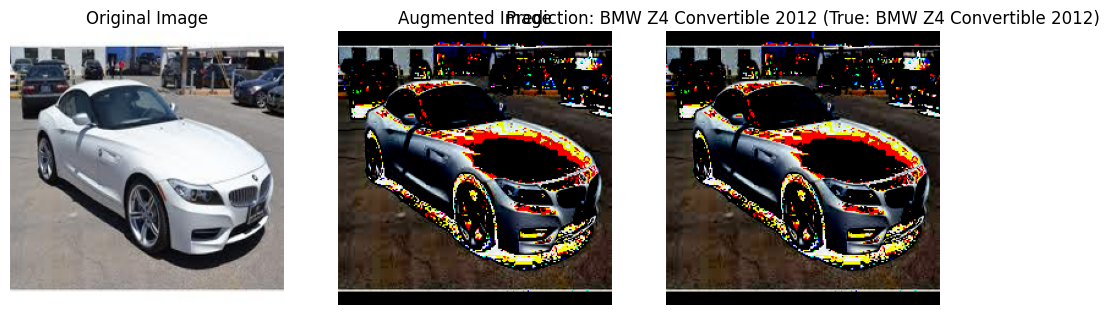

1/1 [==============================] - 0s 42ms/step


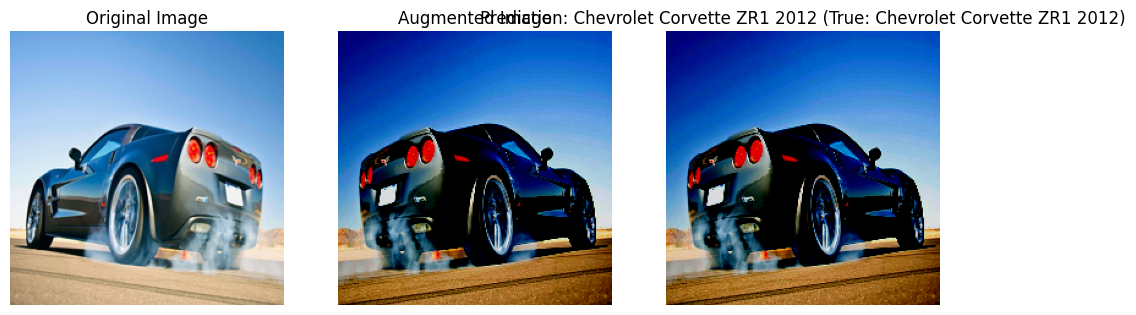

1/1 [==============================] - 0s 42ms/step


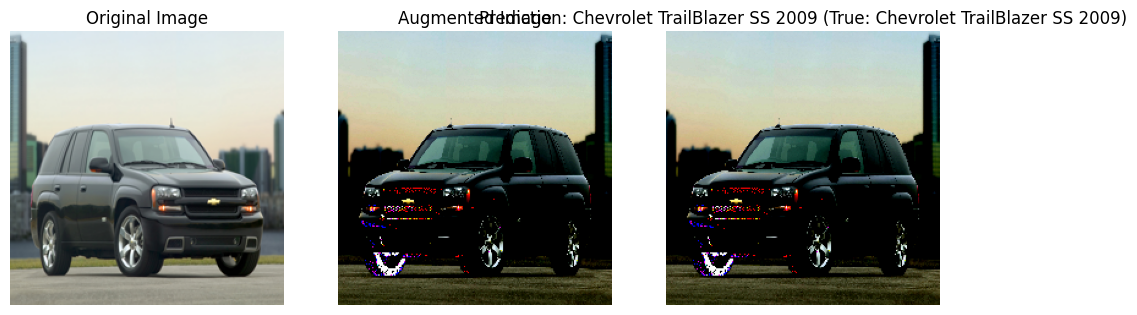

1/1 [==============================] - 0s 42ms/step


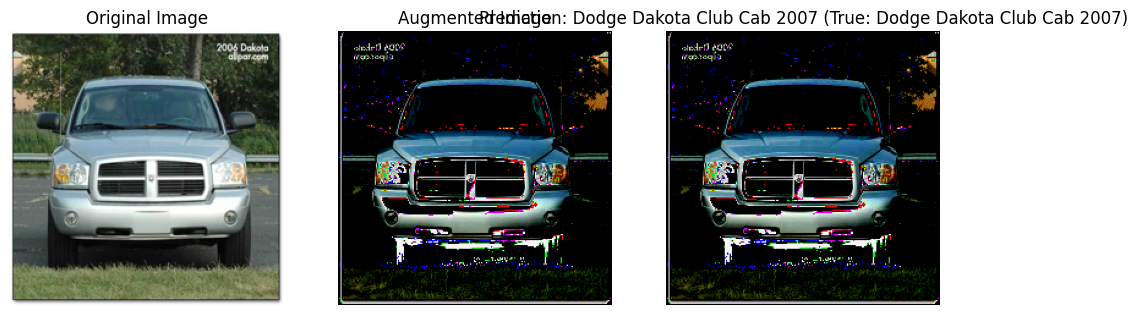

1/1 [==============================] - 0s 42ms/step


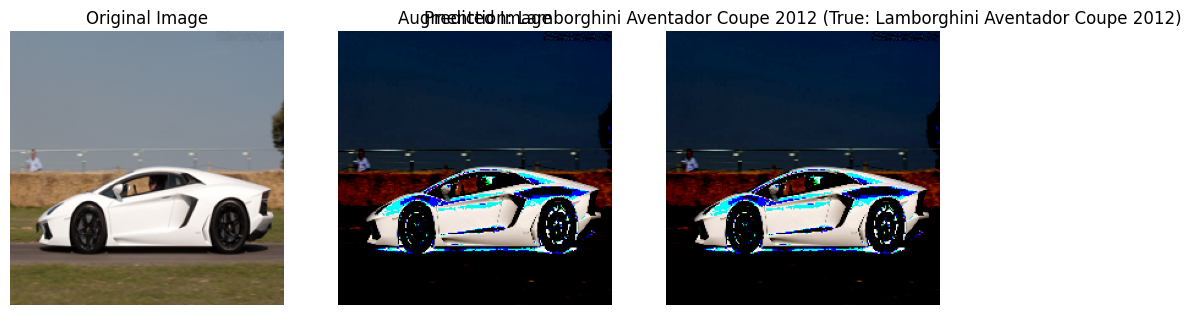

1/1 [==============================] - 0s 42ms/step


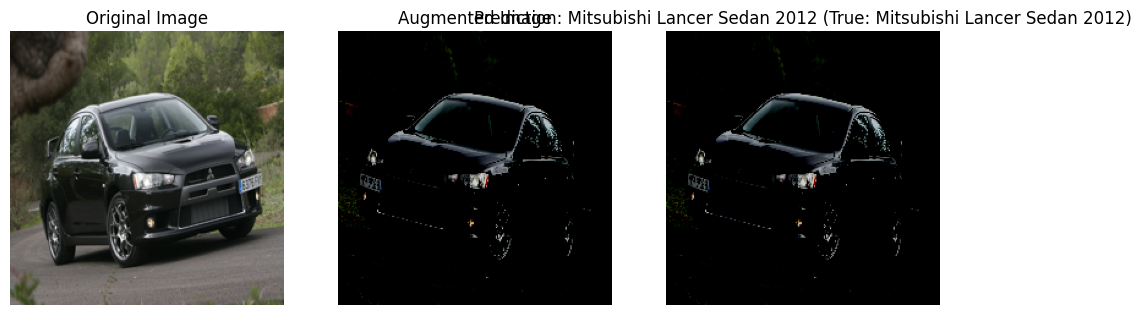

1/1 [==============================] - 0s 42ms/step


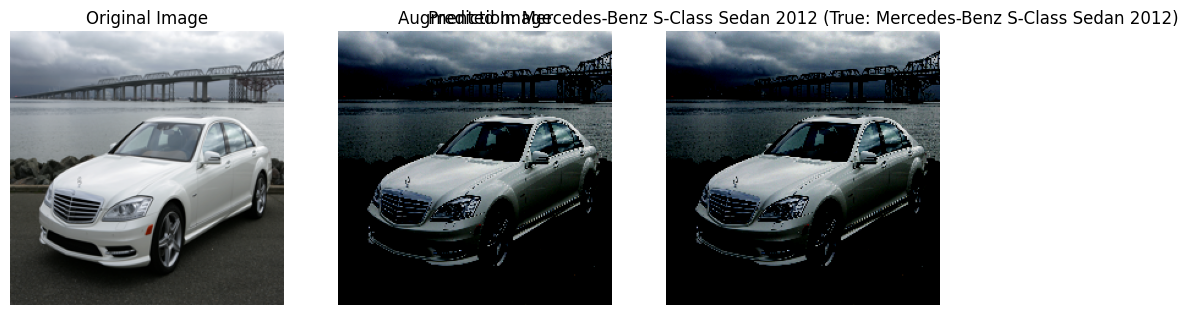

1/1 [==============================] - 0s 43ms/step


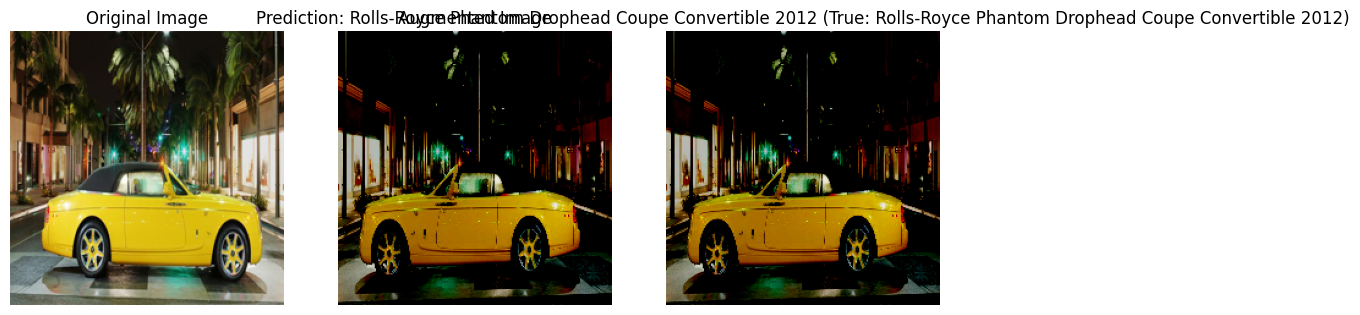

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import ViTFeatureExtractor, TFViTModel
from PIL import Image
import numpy as np
import os


model = create_model()
model.load_weights(checkpoint_path)


def visualize_predictions(original_img, augmented_img, prediction, true_label, class_names):
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    # Augmented image
    plt.subplot(1, 3, 2)
    plt.imshow(augmented_img)
    plt.title("Augmented Image")
    plt.axis('off')

    # Predicted image
    plt.subplot(1, 3, 3)
    plt.imshow(augmented_img)
    plt.title(f"Prediction: {class_names[prediction]} (True: {class_names[true_label]})")
    plt.axis('off')

    plt.show()

def process_image(img_path, class_names):
    original_img = Image.open(img_path)
    original_img = original_img.resize(img_size)


    augmented_img_tensor, _ = load_and_preprocess_image(img_path, None) 
    

    augmented_img_np = augmented_img_tensor.numpy()
    augmented_img_np = np.clip(augmented_img_np * 255, 0, 255).astype(np.uint8)
    augmented_img_np = np.transpose(augmented_img_np, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    augmented_img_pil = Image.fromarray(augmented_img_np)

    augmented_img_tensor = tf.expand_dims(augmented_img_tensor, axis=0)
    prediction = model.predict(augmented_img_tensor)
    predicted_class = np.argmax(prediction, axis=1)[0]

    true_label = classes.index(img_path.split('/')[-2])

    visualize_predictions(original_img, augmented_img_pil, predicted_class, true_label, class_names)


sample_img_paths = [
"/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/AM General Hummer SUV 2000/00076.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/Audi S6 Sedan 2011/00110.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/BMW 6 Series Convertible 2007/00037.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/BMW Z4 Convertible 2012/00612.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/Chevrolet Corvette ZR1 2012/00808.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/Chevrolet TrailBlazer SS 2009/00555.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/Dodge Dakota Club Cab 2007/00029.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/Lamborghini Aventador Coupe 2012/00464.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/Mitsubishi Lancer Sedan 2012/00896.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/Mercedes-Benz S-Class Sedan 2012/00025.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/Rolls-Royce Phantom Drophead Coupe Convertible 2012/00203.jpg"
    
]

for img_path in sample_img_paths:
    process_image(img_path, classes)


1/1 [==============================] - 0s 43ms/step


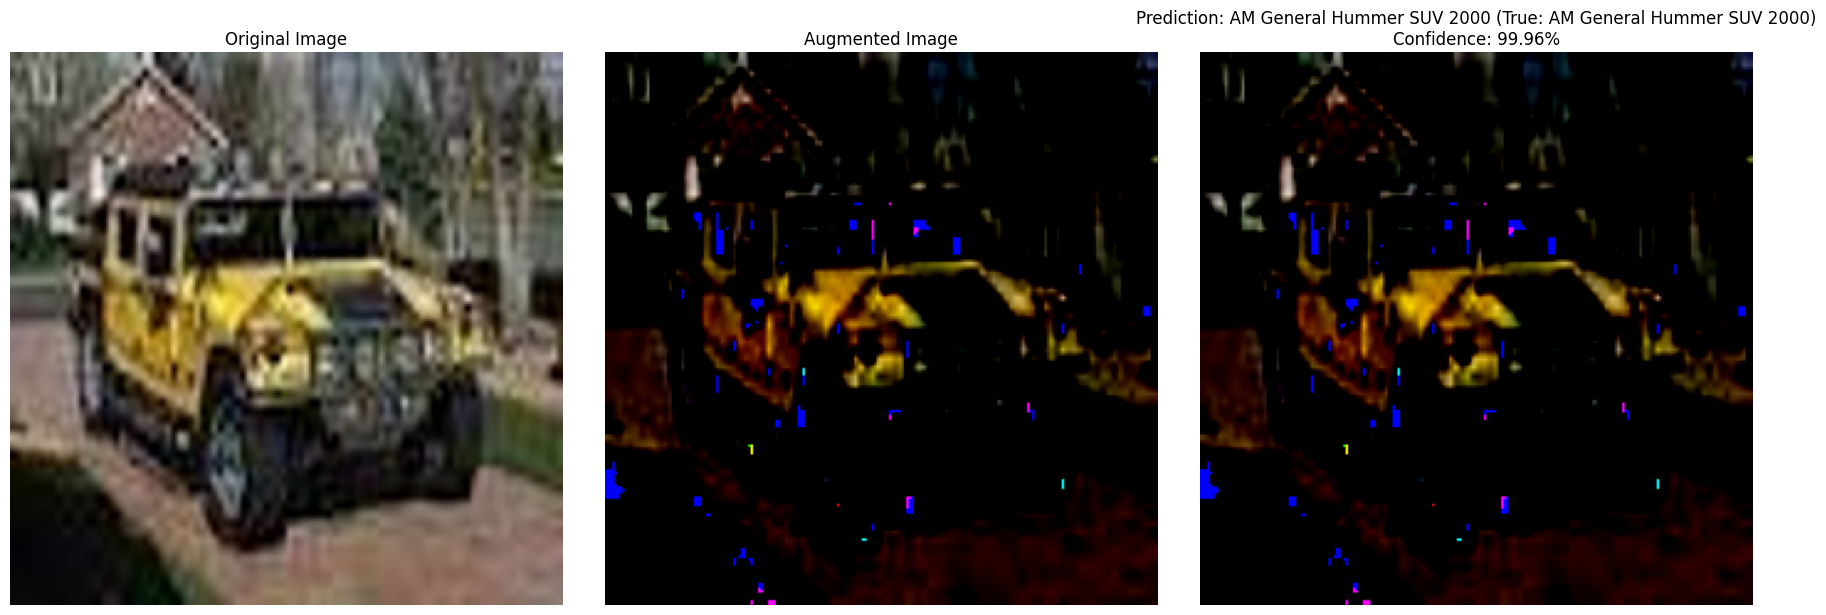

1/1 [==============================] - 0s 43ms/step


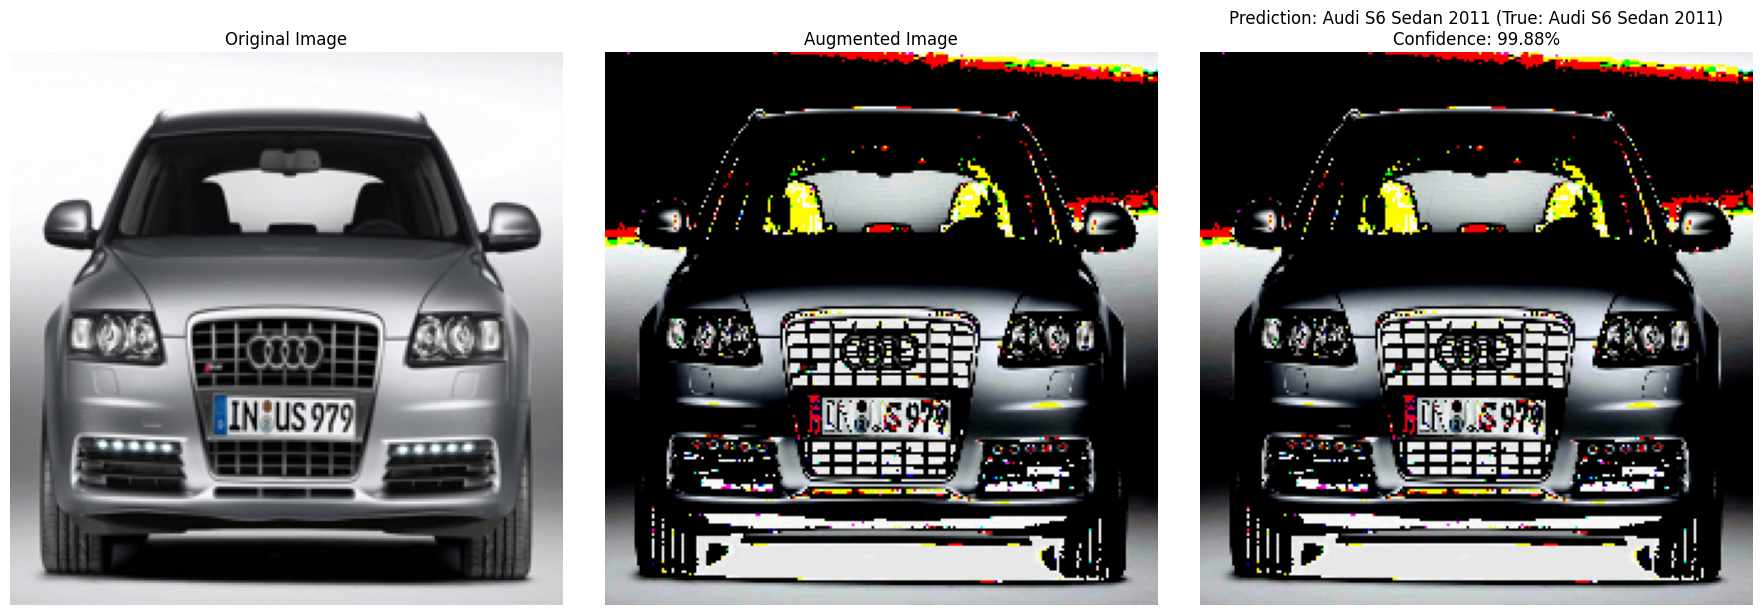

1/1 [==============================] - 0s 43ms/step


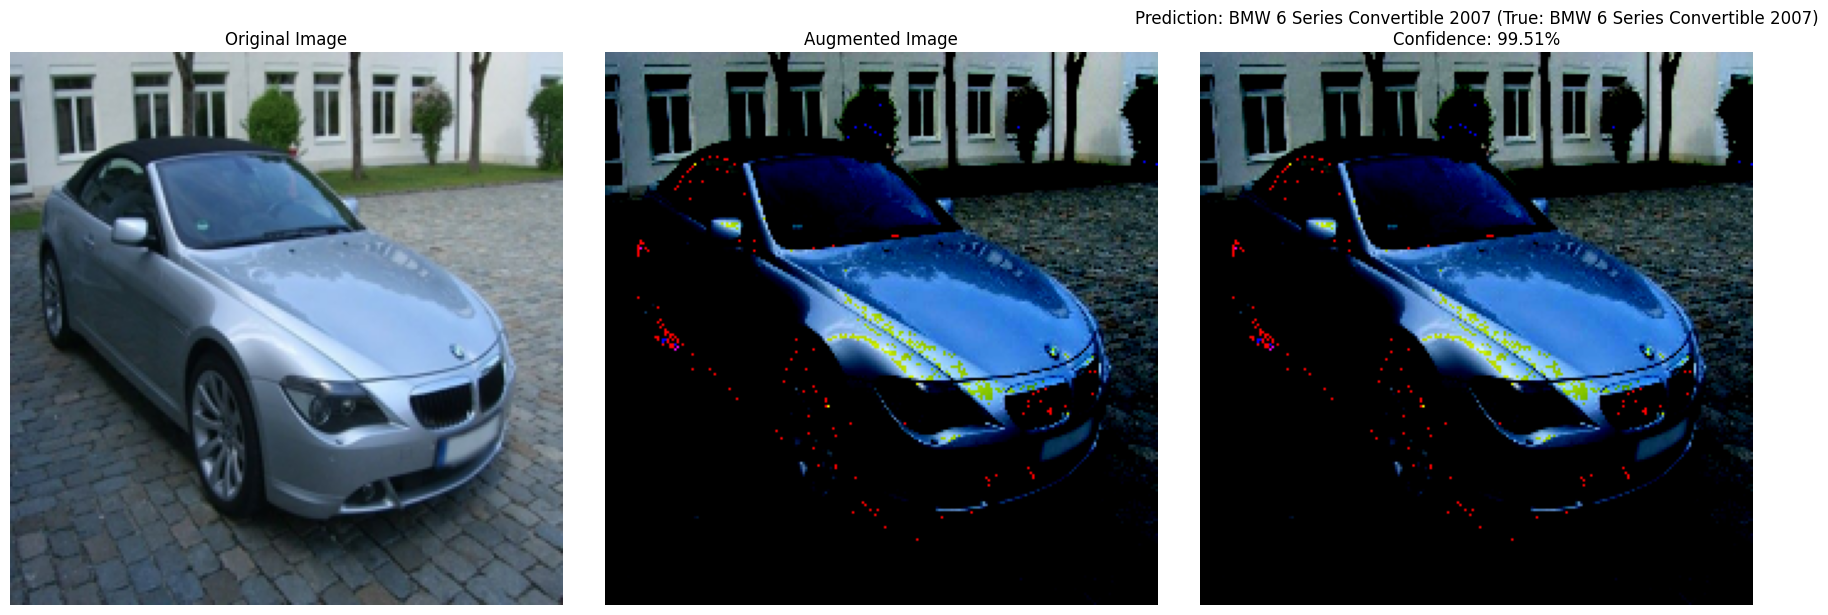

1/1 [==============================] - 0s 42ms/step


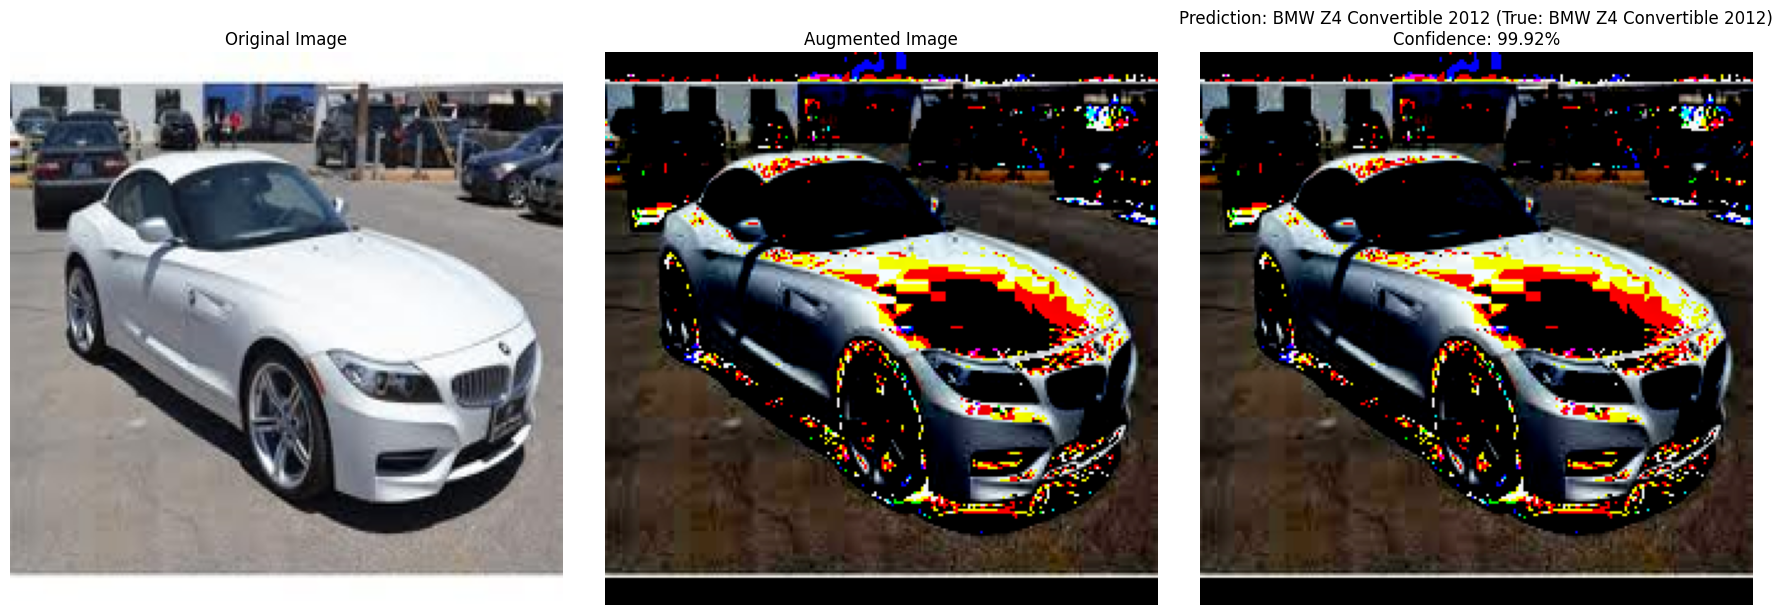

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image

def visualize_predictions_with_confidence(original_img, augmented_img, prediction, true_label, class_names, confidence_scores):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')


    axes[1].imshow(augmented_img)
    axes[1].set_title("Augmented Image")
    axes[1].axis('off')


    axes[2].imshow(augmented_img)
    axes[2].set_title(f"Prediction: {class_names[prediction]} (True: {class_names[true_label]})\nConfidence: {confidence_scores[prediction]*100:.2f}%")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def process_image_and_visualize(img_path, class_names):
    original_img = Image.open(img_path)
    original_img = original_img.resize(img_size)

 
    augmented_img_tensor, _ = load_and_preprocess_image(img_path, None) 
    
 
    augmented_img_np = augmented_img_tensor.numpy()
    augmented_img_np = np.clip(augmented_img_np * 255, 0, 255).astype(np.uint8)
    augmented_img_np = np.transpose(augmented_img_np, (1, 2, 0))  
    augmented_img_pil = Image.fromarray(augmented_img_np)

    
    augmented_img_tensor = tf.expand_dims(augmented_img_tensor, axis=0)
    prediction_probs = model.predict(augmented_img_tensor)[0]
    predicted_class = np.argmax(prediction_probs)
    confidence_scores = prediction_probs

    
    true_label = classes.index(img_path.split('/')[-2])
    
   
    visualize_predictions_with_confidence(original_img, augmented_img_pil, predicted_class, true_label, class_names, confidence_scores)


sample_img_paths = [
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/AM General Hummer SUV 2000/00076.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/Audi S6 Sedan 2011/00110.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/BMW 6 Series Convertible 2007/00037.jpg",
    "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/BMW Z4 Convertible 2012/00612.jpg",
 
]


for img_path in sample_img_paths:
    process_image_and_visualize(img_path, classes)
